In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
from scipy import stats
from sklearn.preprocessing import StandardScaler, RobustScaler
from tqdm import tqdm

class SomaboticsJointCycleGAN:
    def __init__(self, sequence_length=400, n_joints=7):
        """
        Initialize CycleGAN for joint position data transformation

        Args:
            sequence_length: Length of movement sequence in frames
            n_joints: Number of joints to track (7 by default)
        """
        self.sequence_length = sequence_length
        self.n_joints = n_joints
        self.signal_shape = (sequence_length, n_joints)

        # Initialize generators and discriminators
        self.G = self.build_generator(name='G_robot2human')  # Robot to Human
        self.F = self.build_generator(name='F_human2robot')  # Human to Robot
        self.D_H = self.build_discriminator(name='D_human')  # Discriminator for human
        self.D_R = self.build_discriminator(name='D_robot')  # Discriminator for robot

        # Loss weights
        self.lambda_cycle = 10.0
        self.lambda_identity = 5.0
        self.lambda_smooth = 2.0

        # Optimizers
        self.g_optimizer = tf.keras.optimizers.Adam(2e-5, beta_1=0.5)
        self.f_optimizer = tf.keras.optimizers.Adam(2e-5, beta_1=0.5)
        self.d_h_optimizer = tf.keras.optimizers.Adam(2e-5, beta_1=0.5)
        self.d_r_optimizer = tf.keras.optimizers.Adam(2e-5, beta_1=0.5)

    def build_generator(self, name=None):
        """Generator architecture with residual blocks for joint trajectories"""
        input_signal = layers.Input(shape=self.signal_shape)

        # Initial convolution
        x = layers.Conv1D(64, 7, padding='same')(input_signal) #was 64
        x = layers.LayerNormalization()(x)
        x = layers.ReLU()(x)

        # Downsampling blocks
        for filters in [256, 128, 64]: #was 128, 256
            x = self._downsample_block(x, filters)

        # Residual blocks
        for _ in range(9): #was 9
            x = self._residual_block(x)

        # Upsampling blocks
        for filters in [128, 64, 32]: #was 128, 64
            x = self._upsample_block(x, filters)

        # Output layer - no activation to allow unrestricted joint positions
        x = layers.Conv1D(self.n_joints, 7, padding='same')(x)

        return models.Model(input_signal, x, name=name)

    def build_discriminator(self, name=None):
        """Discriminator for distinguishing real/fake joint trajectories"""
        input_signal = layers.Input(shape=self.signal_shape)

        x = layers.Conv1D(64, 4, strides=2, padding='same')(input_signal)
        x = layers.LeakyReLU(0.2)(x)

        filters = [128, 256, 512]
        for f in filters:
            x = layers.Conv1D(f, 4, strides=2, padding='same')(x)
            x = layers.LayerNormalization()(x)
            x = layers.LeakyReLU(0.2)(x)

        # Output layer (no activation - using least squares GAN loss)
        x = layers.Conv1D(1, 4, padding='same')(x)

        return models.Model(input_signal, x, name=name)

    def _downsample_block(self, x, filters):
        x = layers.Conv1D(filters, 3, strides=2, padding='same')(x)
        x = layers.LayerNormalization()(x)
        x = layers.ReLU()(x)
        return x

    def _upsample_block(self, x, filters):
        x = layers.Conv1DTranspose(filters, 3, strides=2, padding='same')(x)
        x = layers.LayerNormalization()(x)
        x = layers.ReLU()(x)
        return x

    def _residual_block(self, x):
        dim = x.shape[-1]
        input_tensor = x

        x = layers.Conv1D(dim, 3, padding='same')(x)
        x = layers.LayerNormalization()(x)
        x = layers.ReLU()(x)

        x = layers.Conv1D(dim, 3, padding='same')(x)
        x = layers.LayerNormalization()(x)

        return layers.Add()([input_tensor, x])

    @tf.function
    def train_step(self, robot_joints, human_joints):
        """
        Single training step for the CycleGAN

        Args:
            robot_joints: Batch of robot joint trajectories
            human_joints: Batch of human joint trajectories
        """
        with tf.GradientTape(persistent=True) as tape:
            # Generate fake samples
            fake_human = self.G(robot_joints, training=True)
            fake_robot = self.F(human_joints, training=True)

            # Reconstruct original samples
            cycled_robot = self.F(fake_human, training=True)
            cycled_human = self.G(fake_robot, training=True)

            # Identity mapping
            same_robot = self.F(robot_joints, training=True)
            same_human = self.G(human_joints, training=True)

            # Discriminator outputs
            disc_real_robot = self.D_R(robot_joints, training=True)
            disc_fake_robot = self.D_R(fake_robot, training=True)
            disc_real_human = self.D_H(human_joints, training=True)
            disc_fake_human = self.D_H(fake_human, training=True)

            # Generator losses
            gen_h_loss = tf.reduce_mean(tf.square(disc_fake_human - 1))
            gen_r_loss = tf.reduce_mean(tf.square(disc_fake_robot - 1))


            # Cycle consistency losses
            cycle_loss = (tf.reduce_mean(tf.abs(robot_joints - cycled_robot)) +
                         tf.reduce_mean(tf.abs(human_joints - cycled_human))) * self.lambda_cycle

            cycle_loss_raw = (tf.reduce_mean(tf.abs(robot_joints - cycled_robot)) +
                       tf.reduce_mean(tf.abs(human_joints - cycled_human)))

            cycle_loss = tf.clip_by_value(cycle_loss_raw, 0.0, 100.0) * self.lambda_cycle

            # Identity losses
            identity_loss = (tf.reduce_mean(tf.abs(robot_joints - same_robot)) +
                           tf.reduce_mean(tf.abs(human_joints - same_human))) * self.lambda_identity

            identity_loss_raw = (tf.reduce_mean(tf.abs(robot_joints - same_robot)) +
                           tf.reduce_mean(tf.abs(human_joints - same_human)))

            identity_loss = tf.clip_by_value(identity_loss_raw, 0.0, 100.0) * self.lambda_identity

            total_gen_loss = gen_h_loss + gen_r_loss + cycle_loss + identity_loss

            total_gen_loss = tf.clip_by_value(total_gen_loss, 0.0, 10000.0)

            # Enhanced temporal smoothness loss with multi-scale analysis
            def temporal_smoothness_loss(signal):
                # First-order differences (velocity)
                diff1 = signal[:, 1:, :] - signal[:, :-1, :]
                # Second-order differences (acceleration)
                diff2 = diff1[:, 1:, :] - diff1[:, :-1, :]
                # Third-order differences (jerk) - important for natural motion
                diff3 = diff2[:, 1:, :] - diff2[:, :-1, :]

                return (tf.reduce_mean(tf.square(diff1)) * 5.0 +
                       tf.reduce_mean(tf.square(diff2)) * 10.0 +
                       tf.reduce_mean(tf.square(diff3)) * 15.0)  # Penalize jerk more

            # Biomechanical plausibility loss - ensures joint angles stay within reasonable ranges
            def biomechanical_plausibility_loss(joint_positions):
                # For simplicity, penalize extreme values - customize based on actual joint limits
                extreme_penalty = tf.reduce_mean(tf.square(tf.maximum(0.0, tf.abs(joint_positions) - 0.8)))
                return extreme_penalty * 5.0

            # Joint correlation loss - human movements have coordination between joints
            def joint_correlation_loss(human_joints, fake_human_joints):
                # Calculate pairwise correlations between joints in real human data
                def get_correlation_pattern(joint_data):
                    # Reshape to [batch_size * seq_length, n_joints]
                    flat_data = tf.reshape(joint_data, [-1, joint_data.shape[-1]])
                    # Get mean per joint
                    joint_means = tf.reduce_mean(flat_data, axis=0, keepdims=True)
                    # Center the data
                    centered = flat_data - joint_means
                    # Compute covariance matrix
                    cov = tf.matmul(centered, centered, transpose_a=True)
                    return cov

                real_correlations = get_correlation_pattern(human_joints)
                fake_correlations = get_correlation_pattern(fake_human_joints)

                # Penalize difference in correlation patterns
                return tf.reduce_mean(tf.square(real_correlations - fake_correlations)) * 2.0

            # Compute all losses
            smoothness_loss = (temporal_smoothness_loss(fake_human) +
                             temporal_smoothness_loss(fake_robot)) * self.lambda_smooth

            biomech_loss = (biomechanical_plausibility_loss(fake_human) +
                          biomechanical_plausibility_loss(fake_robot)) * 2.0

            correlation_loss = joint_correlation_loss(human_joints, fake_human) * 3.0

            # Total generator loss with adjusted weights
            # total_gen_loss = (gen_h_loss +
            #                 gen_r_loss +
            #                 cycle_loss +
            #                 identity_loss +
            #                 smoothness_loss +
            #                 biomech_loss +
            #                 correlation_loss)

            # Discriminator losses
            disc_h_loss = 0.5 * (tf.reduce_mean(tf.square(disc_fake_human)) +
                                tf.reduce_mean(tf.square(disc_real_human - 1)))
            disc_r_loss = 0.5 * (tf.reduce_mean(tf.square(disc_fake_robot)) +
                                tf.reduce_mean(tf.square(disc_real_robot - 1)))

        # Calculate gradients
        generator_grads = tape.gradient(total_gen_loss,
                                      self.G.trainable_variables + self.F.trainable_variables)


    # Add clipping to prevent explosion
        clipped_gen_grads = [tf.clip_by_norm(g, 1.0) for g in generator_grads if g is not None]

    # Apply gradients
        self.g_optimizer.apply_gradients(
            zip(clipped_gen_grads, self.G.trainable_variables + self.F.trainable_variables))



        disc_h_grads = tape.gradient(disc_h_loss, self.D_H.trainable_variables)
        disc_r_grads = tape.gradient(disc_r_loss, self.D_R.trainable_variables)

        # Apply gradients
        self.g_optimizer.apply_gradients(
            zip(generator_grads, self.G.trainable_variables + self.F.trainable_variables))
        self.d_h_optimizer.apply_gradients(
            zip(disc_h_grads, self.D_H.trainable_variables))
        self.d_r_optimizer.apply_gradients(
            zip(disc_r_grads, self.D_R.trainable_variables))

        return {
            'total_gen_loss': total_gen_loss,
            'disc_h_loss': disc_h_loss,
            'disc_r_loss': disc_r_loss,
            'cycle_loss': cycle_loss,
            'identity_loss': identity_loss,
            'smoothness_loss': smoothness_loss,
            'biomech_loss': biomech_loss,
            'correlation_loss': correlation_loss
        }

    def train(self, robot_data, human_data, epochs=200, batch_size=32):
        """
        Train the CycleGAN

        Args:
            robot_data: numpy array of robot joint trajectories [n_samples, seq_length, n_joints]
            human_data: numpy array of human joint trajectories [n_samples, seq_length, n_joints]
            epochs: Number of training epochs
            batch_size: Batch size for training

        Returns:
            Training history
        """
        history = []

        for epoch in range(epochs):
            # Sample random batches
            idx_r = np.random.randint(0, len(robot_data), batch_size)
            idx_h = np.random.randint(0, len(human_data), batch_size)

            batch_robot = robot_data[idx_r]
            batch_human = human_data[idx_h]

            # Train step
            metrics = self.train_step(batch_robot, batch_human)
            history.append(metrics)

            if epoch % 10 == 0:
                print(f"Epoch {epoch}/{epochs}")
                print(f"Generator Loss: {metrics['total_gen_loss']:.4f}")
                print(f"Discriminator H Loss: {metrics['disc_h_loss']:.4f}")
                print(f"Discriminator R Loss: {metrics['disc_r_loss']:.4f}")
                print(f"Cycle Loss: {metrics['cycle_loss']:.4f}")
                print(f"Identity Loss: {metrics['identity_loss']:.4f}")
                print(f"Smoothness Loss: {metrics['smoothness_loss']:.4f}")
                print(f"Biomechanical Loss: {metrics['biomech_loss']:.4f}")
                print(f"Correlation Loss: {metrics['correlation_loss']:.4f}")
                print("-" * 50)

                # Visualize progress every 50 epochs
                if epoch % 50 == 0:
                    self.visualize_results(batch_robot, batch_human, epoch)

        return history

    def humanize_robot_movement(self, robot_joint_data):
        """
        Transform robot joint movement to be more human-like

        Args:
            robot_joint_data: Robot joint trajectory [n_samples, seq_length, n_joints]

        Returns:
            Humanized joint trajectory
        """
        return self.G.predict(robot_joint_data)

    def robotize_human_movement(self, human_joint_data):
        """
        Transform human joint movement to be more robot-like

        Args:
            human_joint_data: Human joint trajectory [n_samples, seq_length, n_joints]

        Returns:
            Robot-like joint trajectory
        """
        return self.F.predict(human_joint_data)

    def visualize_results(self, robot_data, human_data, epoch=None):
        """
        Visualize the results of the CycleGAN

        Args:
            robot_data: Robot joint trajectories
            human_data: Human joint trajectories
            epoch: Current training epoch (optional)
        """
        # Get the first sample from each batch
        robot_sample = robot_data[0:1]
        human_sample = human_data[0:1]

        # Generate fake samples
        humanized_robot = self.G.predict(robot_sample)
        robotized_human = self.F.predict(human_sample)

        # Reconstruct original samples
        cycled_robot = self.F.predict(humanized_robot)
        cycled_human = self.G.predict(robotized_human)

        # Plot the results for a single joint (joint 0 for simplicity)
        plt.figure(figsize=(15, 10))

        # Robot to Human and back (top row)
        plt.subplot(2, 3, 1)
        plt.plot(robot_sample[0, :, 0], label='Original Robot Joint 1')
        plt.title('Original Robot')
        plt.grid(True)

        plt.subplot(2, 3, 2)
        plt.plot(humanized_robot[0, :, 0], label='Humanized Robot Joint 1')
        plt.title('Humanized Robot (G(robot))')
        plt.grid(True)

        plt.subplot(2, 3, 3)
        plt.plot(cycled_robot[0, :, 0], label='Cycled Robot Joint 1')
        plt.plot(robot_sample[0, :, 0], 'r--', alpha=0.5, label='Original')
        plt.title('Cycled Robot (F(G(robot)))')
        plt.grid(True)

        # Human to Robot and back (bottom row)
        plt.subplot(2, 3, 4)
        plt.plot(human_sample[0, :, 0], label='Original Human Joint 1')
        plt.title('Original Human')
        plt.grid(True)

        plt.subplot(2, 3, 5)
        plt.plot(robotized_human[0, :, 0], label='Robotized Human Joint 1')
        plt.title('Robotized Human (F(human))')
        plt.grid(True)

        plt.subplot(2, 3, 6)
        plt.plot(cycled_human[0, :, 0], label='Cycled Human Joint 1')
        plt.plot(human_sample[0, :, 0], 'r--', alpha=0.5, label='Original')
        plt.title('Cycled Human (G(F(human)))')
        plt.grid(True)

        plt.tight_layout()

        # Save the figure if an epoch is provided
        if epoch is not None:
            plt.savefig(f'cyclegan_progress_epoch_{epoch}.png')

        plt.show()

        # Also plot all 7 joints for the humanized robot motion
        plt.figure(figsize=(15, 10))
        for joint in range(self.n_joints):
            plt.subplot(4, 2, joint+1)
            plt.plot(robot_sample[0, :, joint], 'b--', label=f'Robot Joint {joint+1}')
            plt.plot(humanized_robot[0, :, joint], 'g-', label=f'Humanized Joint {joint+1}')
            plt.title(f'Joint {joint+1}')
            plt.grid(True)
            plt.legend()

        plt.tight_layout()

        if epoch is not None:
            plt.savefig(f'humanized_joints_epoch_{epoch}.png')

        plt.show()

In [14]:
from scipy import signal

def smooth_human_data(joint_data, cutoff_freq=0.5, fs=30.0, order=6):
    """
    Apply Butterworth filter to smooth human joint data

    Args:
        joint_data: DataFrame with joint data
        cutoff_freq: Cutoff frequency in Hz (lower = smoother)
        fs: Sampling frequency in Hz
        order: Filter order (higher = steeper cutoff)

    Returns:
        DataFrame with smoothed joint data
    """
    # Create a low-pass Butterworth filter
    nyquist = 0.5 * fs
    normalized_cutoff = cutoff_freq / nyquist
    b, a = signal.butter(order, normalized_cutoff, 'low')

    # Apply to each joint dimension
    smoothed_data = joint_data.copy()
    for col in joint_data.columns:
        if col.startswith('Position'):
            # Apply filter using zero-phase filtering
            smoothed_data[col] = signal.filtfilt(b, a, joint_data[col])

    return smoothed_data

In [15]:

def load_joint_data(data_dir, pattern='*.csv', normalize=True):
    """
    Load joint position data from CSV files

    Args:
        data_dir: Directory containing joint data files
        pattern: File pattern to match
        normalize: Whether to normalize the data

    Returns:
        Dictionary with robot and human joint data
    """
    # Find all files matching the pattern
    files = glob.glob(os.path.join(data_dir, pattern))

    robot_files = [f for f in files if 'robot' in f.lower()]
    human_files = [f for f in files if 'human' in f.lower()]

    robot_data = []
    human_data = []

    # Load robot data
    print(f"Loading {len(robot_files)} robot joint files...")
    for file in tqdm(robot_files):
        try:
            df = pd.read_csv(file)
            # Extract joint position columns (first 7 columns)
            # Adjust column selection based on your data format
            joint_data = df.iloc[:, :7].values

            # Segment the data into windows of sequence_length
            # This is a simplified approach - adapt to your needs
            sequence_length = 400
            stride = 10

            for start in range(0, len(joint_data) - sequence_length + 1, stride):
                segment = joint_data[start:start + sequence_length]
                robot_data.append(segment)

        except Exception as e:
            print(f"Error loading {file}: {str(e)}")

    # Load human data
    print(f"\nLoading {len(human_files)} human joint files...")
    for file in tqdm(human_files):
        try:
            df = pd.read_csv(file)
            smoothed_df = smooth_human_data(
                df,
                cutoff_freq=0.5,  # Lower cutoff = smoother
                fs=30.0,
                order=6           # Higher order = steeper cutoff
            )

            # Extract joint position columns (first 7 columns)
            joint_data = smoothed_df.iloc[:, :7].values

            for start in range(0, len(joint_data) - sequence_length + 1, stride):
                segment = joint_data[start:start + sequence_length]
                human_data.append(segment)

        except Exception as e:
            print(f"Error loading {file}: {str(e)}")

    # Convert to numpy arrays



    robot_data = np.array(robot_data, dtype=np.float32)
    human_data = np.array(human_data, dtype=np.float32)

    print(f"\nLoaded {len(robot_data)} robot segments and {len(human_data)} human segments")

    # Normalize the data if requested
    if normalize:
        # Use robust scaler to handle outliers
        robot_scaler = RobustScaler()
        human_scaler = RobustScaler()

        # Reshape for scaling (combine all samples and timesteps)
        robot_reshaped = robot_data.reshape(-1, robot_data.shape[-1])
        human_reshaped = human_data.reshape(-1, human_data.shape[-1])

        # Fit and transform
        robot_scaled = robot_scaler.fit_transform(robot_reshaped)
        human_scaled = human_scaler.fit_transform(human_reshaped)

        # Reshape back
        robot_data = robot_scaled.reshape(robot_data.shape)
        human_data = human_scaled.reshape(human_data.shape)

        print("Data normalized")

    return {
        'robot_data': robot_data,
        'human_data': human_data,
        'robot_scaler': robot_scaler if normalize else None,
        'human_scaler': human_scaler if normalize else None
    }

In [16]:
def analyze_movements(robot_data, human_data):
    """
    Analyze and compare robot and human movements

    Args:
        robot_data: Robot joint trajectories
        human_data: Human joint trajectories
    """
    print("\nMovement Analysis:")
    print("-" * 50)

    # Calculate general statistics
    print("Robot data shape:", robot_data.shape)
    print("Human data shape:", human_data.shape)

    # Calculate per-joint statistics
    n_joints = robot_data.shape[2]

    print("\nRobot Movement Statistics:")
    for j in range(n_joints):
        joint_data = robot_data[:, :, j]
        print(f"Joint {j+1}:")
        print(f"  Mean: {np.mean(joint_data):.4f}")
        print(f"  Std: {np.std(joint_data):.4f}")
        print(f"  Min: {np.min(joint_data):.4f}")
        print(f"  Max: {np.max(joint_data):.4f}")

    print("\nHuman Movement Statistics:")
    for j in range(n_joints):
        joint_data = human_data[:, :, j]
        print(f"Joint {j+1}:")
        print(f"  Mean: {np.mean(joint_data):.4f}")
        print(f"  Std: {np.std(joint_data):.4f}")
        print(f"  Min: {np.min(joint_data):.4f}")
        print(f"  Max: {np.max(joint_data):.4f}")

    # Calculate movement smoothness
    def calculate_smoothness(data):
        # Calculate jerk (derivative of acceleration)
        velocities = np.diff(data, axis=1)
        accelerations = np.diff(velocities, axis=1)
        jerks = np.diff(accelerations, axis=1)

        # SPARC (Spectral Arc Length) is one measure of smoothness
        # Here we use a simplified measure based on jerk magnitude
        jerk_magnitude = np.mean(np.square(jerks))
        return jerk_magnitude

    robot_smoothness = calculate_smoothness(robot_data)
    human_smoothness = calculate_smoothness(human_data)

    print("\nMovement Smoothness (lower is smoother):")
    print(f"Robot: {robot_smoothness:.6f}")
    print(f"Human: {human_smoothness:.6f}")
    print(f"Human is {robot_smoothness/human_smoothness:.2f}x smoother than robot")

    # Plot sample trajectories
    plt.figure(figsize=(15, 10))

    # Plot joint position for a single sample
    robot_sample = robot_data[0]
    human_sample = human_data[0]

    for j in range(min(n_joints, 7)):  # Plot at most 7 joints
        plt.subplot(7, 2, j*2 + 1)
        plt.plot(robot_sample[:, j])
        plt.title(f'Robot Joint {j+1}')
        plt.grid(True)

        plt.subplot(7, 2, j*2 + 2)
        plt.plot(human_sample[:, j])
        plt.title(f'Human Joint {j+1}')
        plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Plot velocity profiles
    plt.figure(figsize=(15, 10))

    robot_velocity = np.diff(robot_sample, axis=0)
    human_velocity = np.diff(human_sample, axis=0)

    for j in range(min(n_joints, 7)):
        plt.subplot(7, 2, j*2 + 1)
        plt.plot(robot_velocity[:, j])
        plt.title(f'Robot Joint {j+1} Velocity')
        plt.grid(True)

        plt.subplot(7, 2, j*2 + 2)
        plt.plot(human_velocity[:, j])
        plt.title(f'Human Joint {j+1} Velocity')
        plt.grid(True)

    plt.tight_layout()
    plt.show()


In [17]:
def normalize_domains(robot_data, human_data):
    normalized_robot = []
    normalized_human = []

    # Process each joint separately
    for joint in range(7):
        # Extract data for this joint
        robot_joint = robot_data[:, :, joint]
        human_joint = human_data[:, :, joint]

        # Get statistics
        robot_mean = np.mean(robot_joint)
        robot_std = np.std(robot_joint)
        human_mean = np.mean(human_joint)
        human_std = np.std(human_joint)

        # Normalize human to match robot statistics
        # norm_human = ((human_joint - human_mean) / human_std) * robot_std + robot_mean

        # Normalize both to standard normal, then apply same scaling
        robot_norm = (robot_joint - robot_mean) / robot_std
        human_norm = (human_joint - human_mean) / human_std
        target_std = (robot_std + human_std) / 2
        target_mean = (robot_mean + human_mean) / 2
        norm_robot = robot_norm * target_std + target_mean
        norm_human = human_norm * target_std + target_mean

        # Store normalized data
        normalized_robot.append(robot_joint)  # Keep robot as reference
        normalized_human.append(norm_human)   # Adjust human to match

    # Recombine joints
    normalized_robot = np.stack(normalized_robot, axis=-1)
    normalized_human = np.stack(normalized_human, axis=-1)

    return normalized_robot, normalized_human

In [18]:
def remove_outliers(data, m=2.0):
    cleaned_data = data.copy()

    # Process each joint
    for joint in range(data.shape[-1]):
        joint_data = data[:, :, joint]

        # Calculate statistics
        mean = np.mean(joint_data)
        std = np.std(joint_data)

        # Identify outliers (values more than m standard deviations from mean)
        mask = np.abs(joint_data - mean) > (m * std)

        # Replace outliers with boundary values
        upper_bound = mean + m * std
        lower_bound = mean - m * std

        # Clip values
        cleaned_data[:, :, joint] = np.clip(joint_data, lower_bound, upper_bound)

    return cleaned_data

In [19]:
# human_data = remove_outliers(human_data, m=3.0)


In [8]:
# robot_data, human_data = normalize_domains(robot_data, human_data)


Loading 18 robot joint files...


100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 113.43it/s]



Loading 6 human joint files...


100%|█████████████████████████████████████████████| 6/6 [00:00<00:00, 56.49it/s]



Loaded 4991 robot segments and 8817 human segments
Data normalized

Movement Analysis:
--------------------------------------------------
Robot data shape: (4991, 400, 7)
Human data shape: (8817, 400, 7)

Robot Movement Statistics:
Joint 1:
  Mean: 0.3906
  Std: 0.9560
  Min: -1.3548
  Max: 2.9739
Joint 2:
  Mean: 0.0066
  Std: 0.5347
  Min: -0.8916
  Max: 0.8938
Joint 3:
  Mean: 0.1681
  Std: 0.5808
  Min: -0.8790
  Max: 1.2752
Joint 4:
  Mean: -0.1213
  Std: 0.8045
  Min: -2.2984
  Max: 2.3191
Joint 5:
  Mean: 0.1416
  Std: 0.7590
  Min: -1.5143
  Max: 2.8601
Joint 6:
  Mean: -0.0174
  Std: 0.7322
  Min: -2.3993
  Max: 1.9342
Joint 7:
  Mean: 0.3617
  Std: 0.6655
  Min: -0.7680
  Max: 2.2982

Human Movement Statistics:
Joint 1:
  Mean: 0.2211
  Std: 0.7947
  Min: -0.9101
  Max: 2.0599
Joint 2:
  Mean: 0.2388
  Std: 1.0946
  Min: -0.9008
  Max: 4.1986
Joint 3:
  Mean: 0.1154
  Std: 0.7081
  Min: -1.3925
  Max: 2.3549
Joint 4:
  Mean: -0.1048
  Std: 0.7977
  Min: -2.5102
  Max: 1.4529

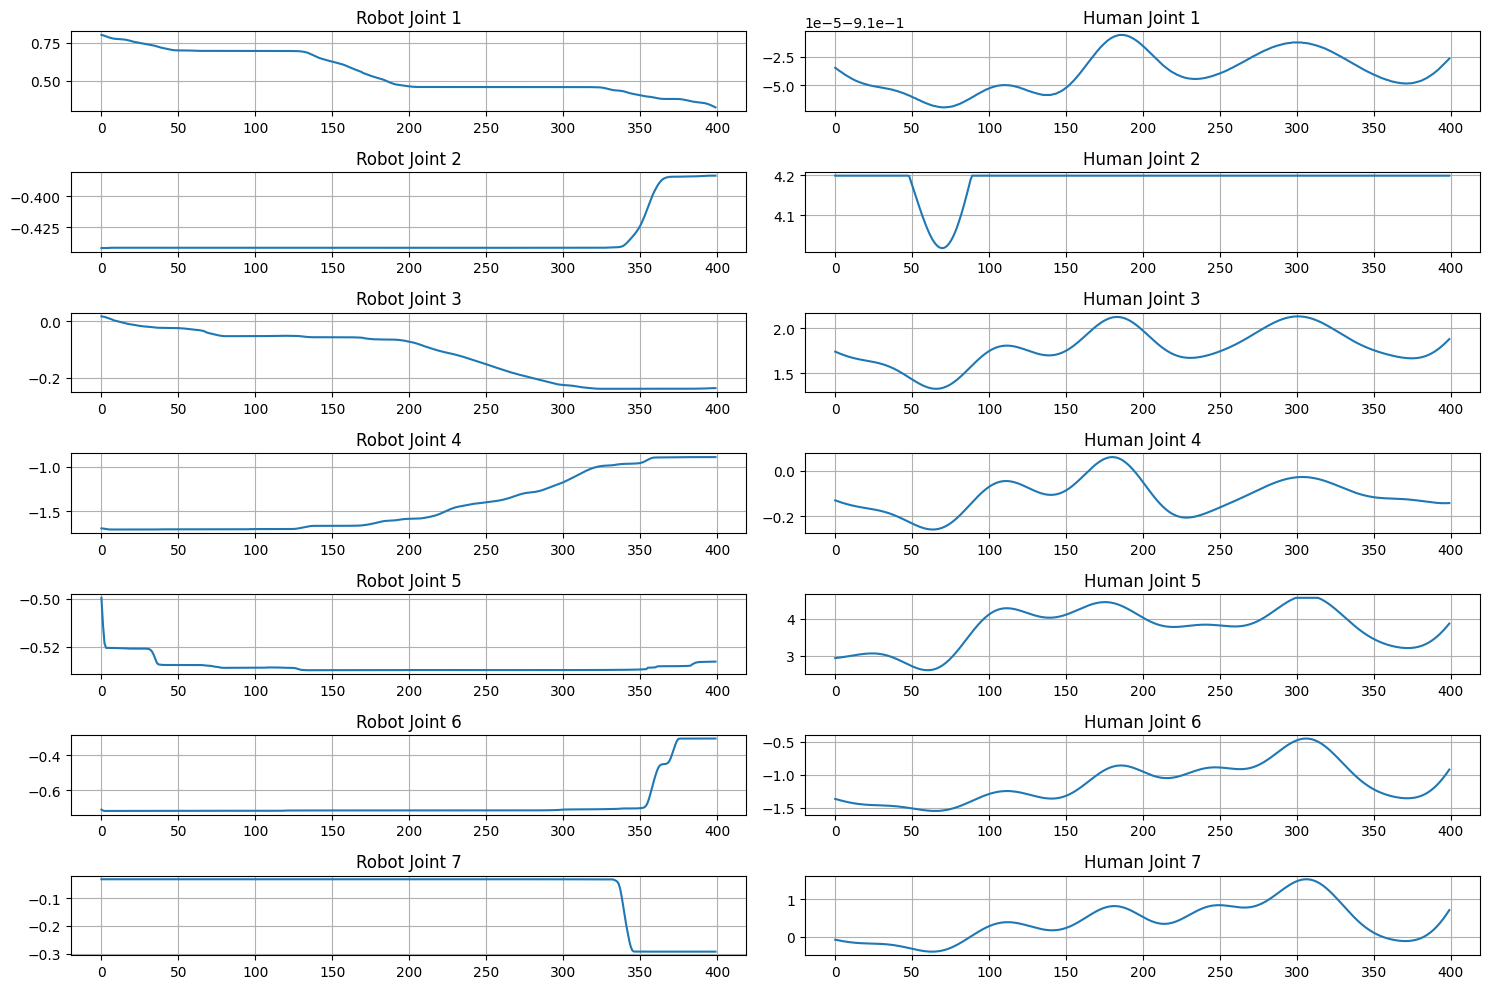

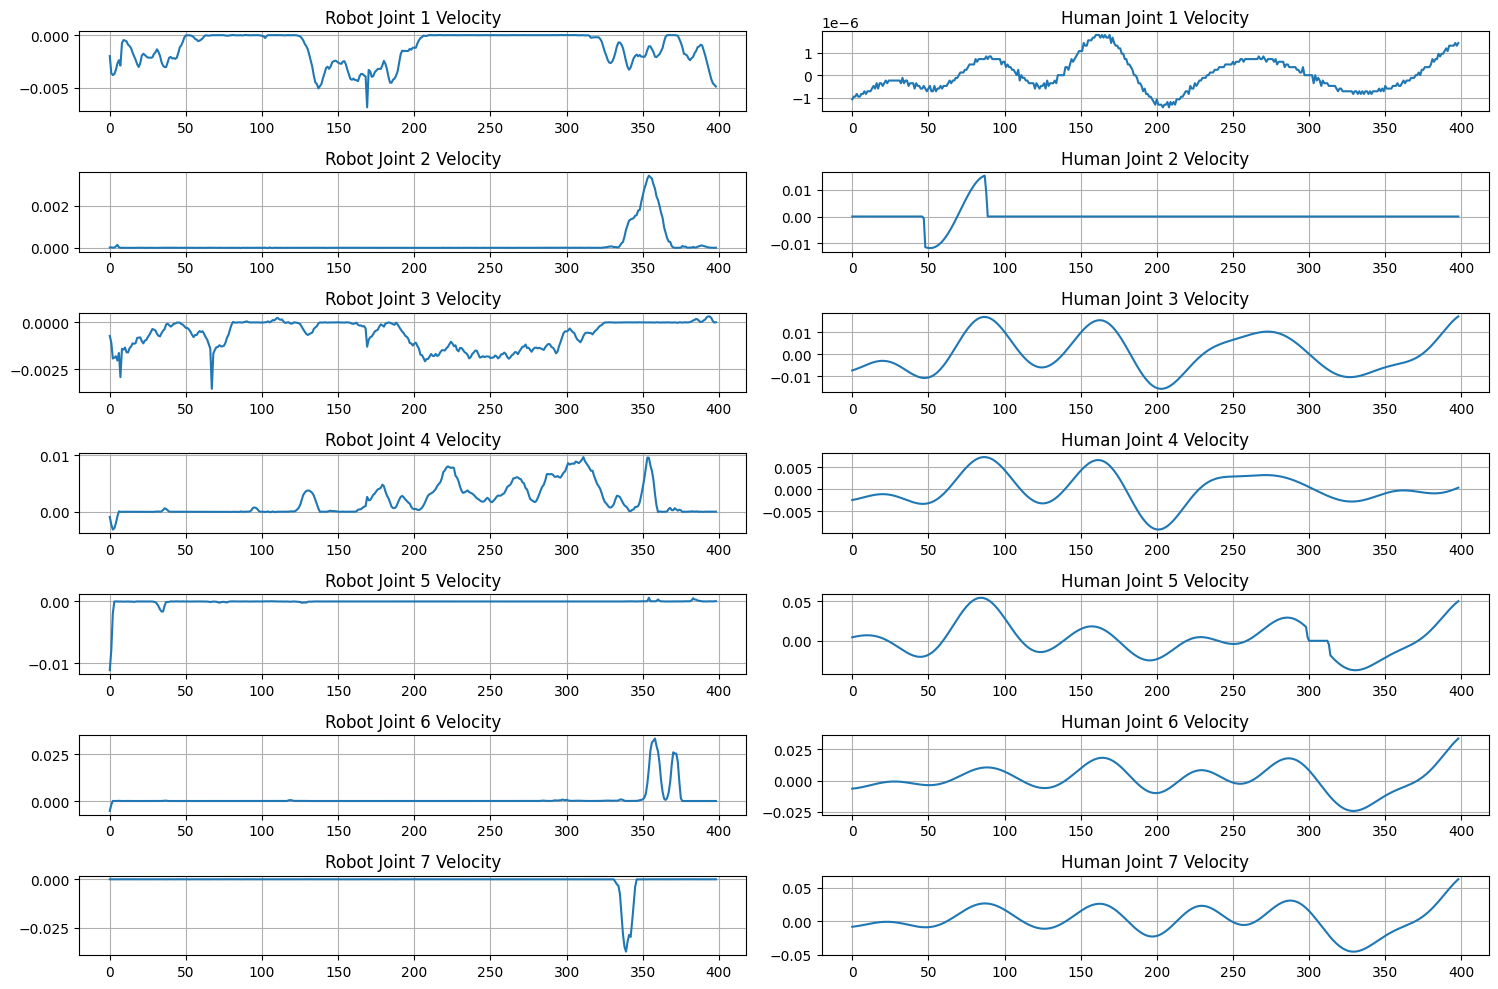

Epoch 0/1000
Generator Loss: 31.2018
Discriminator H Loss: 2.0848
Discriminator R Loss: 2.4011
Cycle Loss: 19.2147
Identity Loss: 9.5864
Smoothness Loss: 1269.4558
Biomechanical Loss: 2.8676
Correlation Loss: 24942442.0000
--------------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step


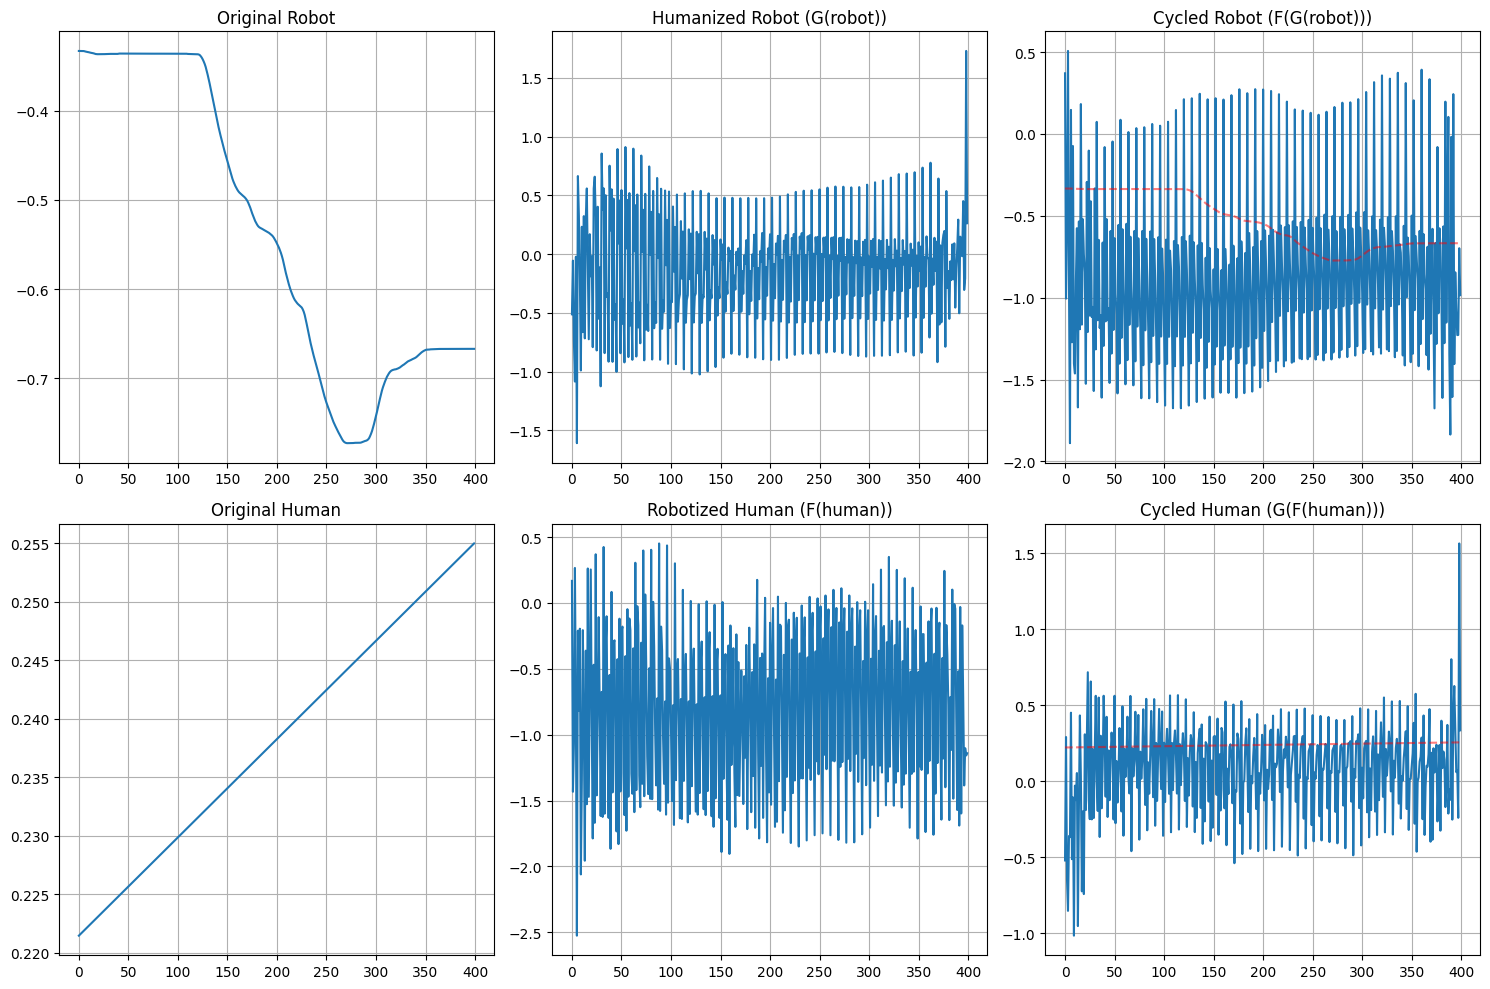

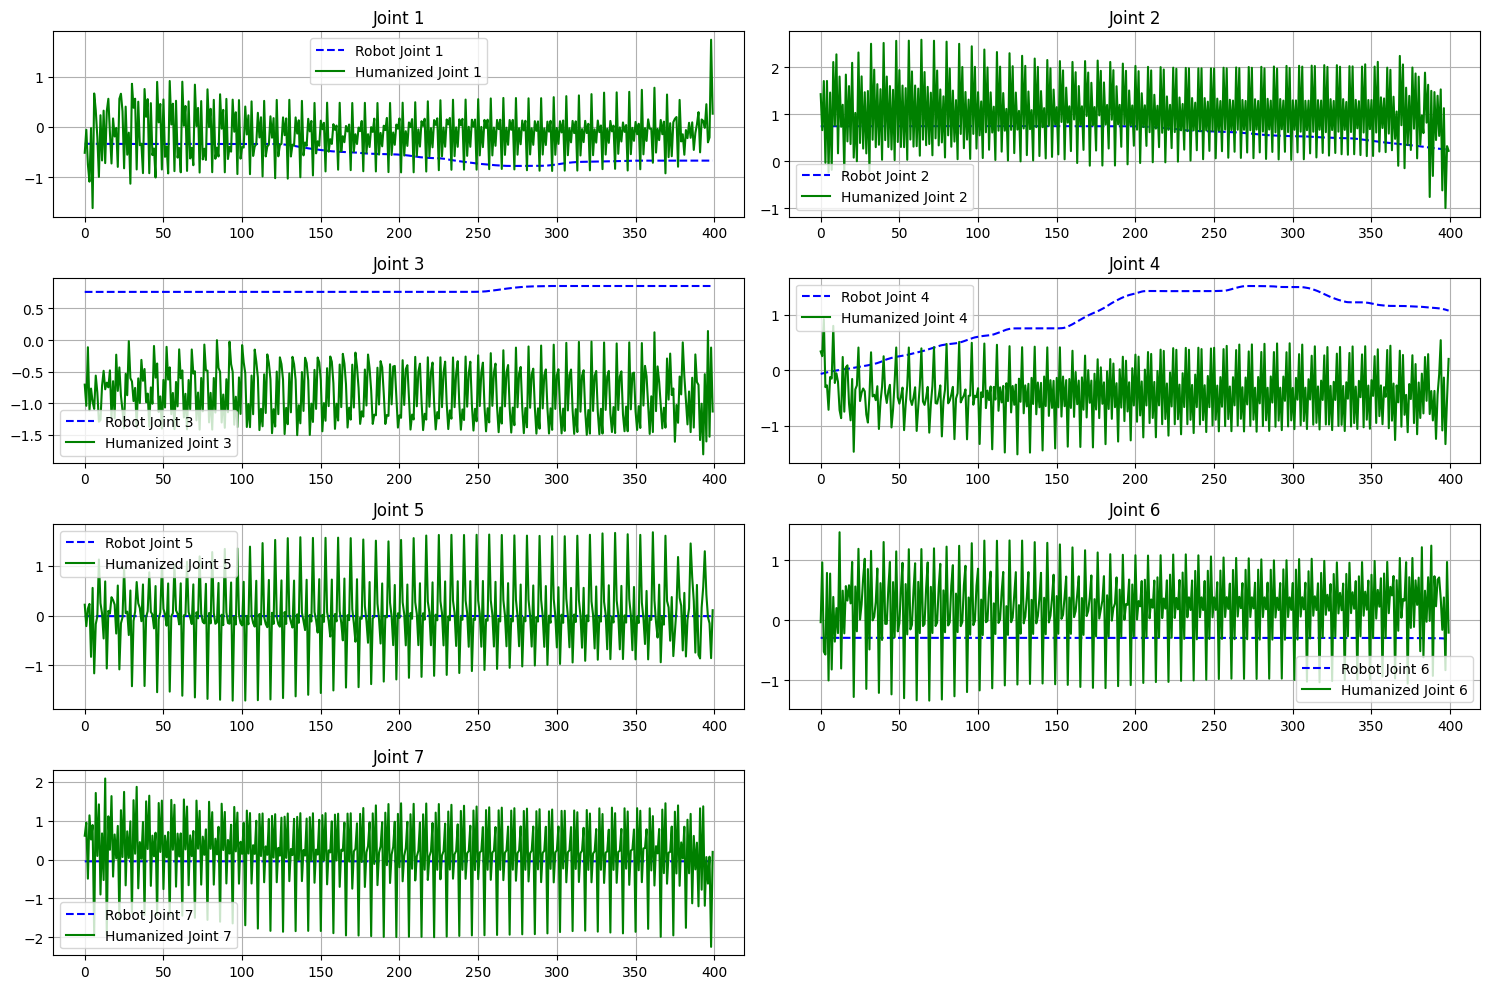

Epoch 10/1000
Generator Loss: 28.8659
Discriminator H Loss: 0.3036
Discriminator R Loss: 0.2154
Cycle Loss: 18.3085
Identity Loss: 9.6727
Smoothness Loss: 905.9305
Biomechanical Loss: 1.6178
Correlation Loss: 380016992.0000
--------------------------------------------------
Epoch 20/1000
Generator Loss: 24.2631
Discriminator H Loss: 0.2594
Discriminator R Loss: 0.1627
Cycle Loss: 15.0179
Identity Loss: 8.0833
Smoothness Loss: 645.4019
Biomechanical Loss: 1.0101
Correlation Loss: 45117940.0000
--------------------------------------------------
Epoch 30/1000
Generator Loss: 23.2307
Discriminator H Loss: 0.2924
Discriminator R Loss: 0.1577
Cycle Loss: 14.4770
Identity Loss: 7.6619
Smoothness Loss: 481.0443
Biomechanical Loss: 0.6143
Correlation Loss: 35209768.0000
--------------------------------------------------
Epoch 40/1000
Generator Loss: 22.0214
Discriminator H Loss: 0.1988
Discriminator R Loss: 0.1914
Cycle Loss: 13.5381
Identity Loss: 7.1285
Smoothness Loss: 348.5093
Biomechanical

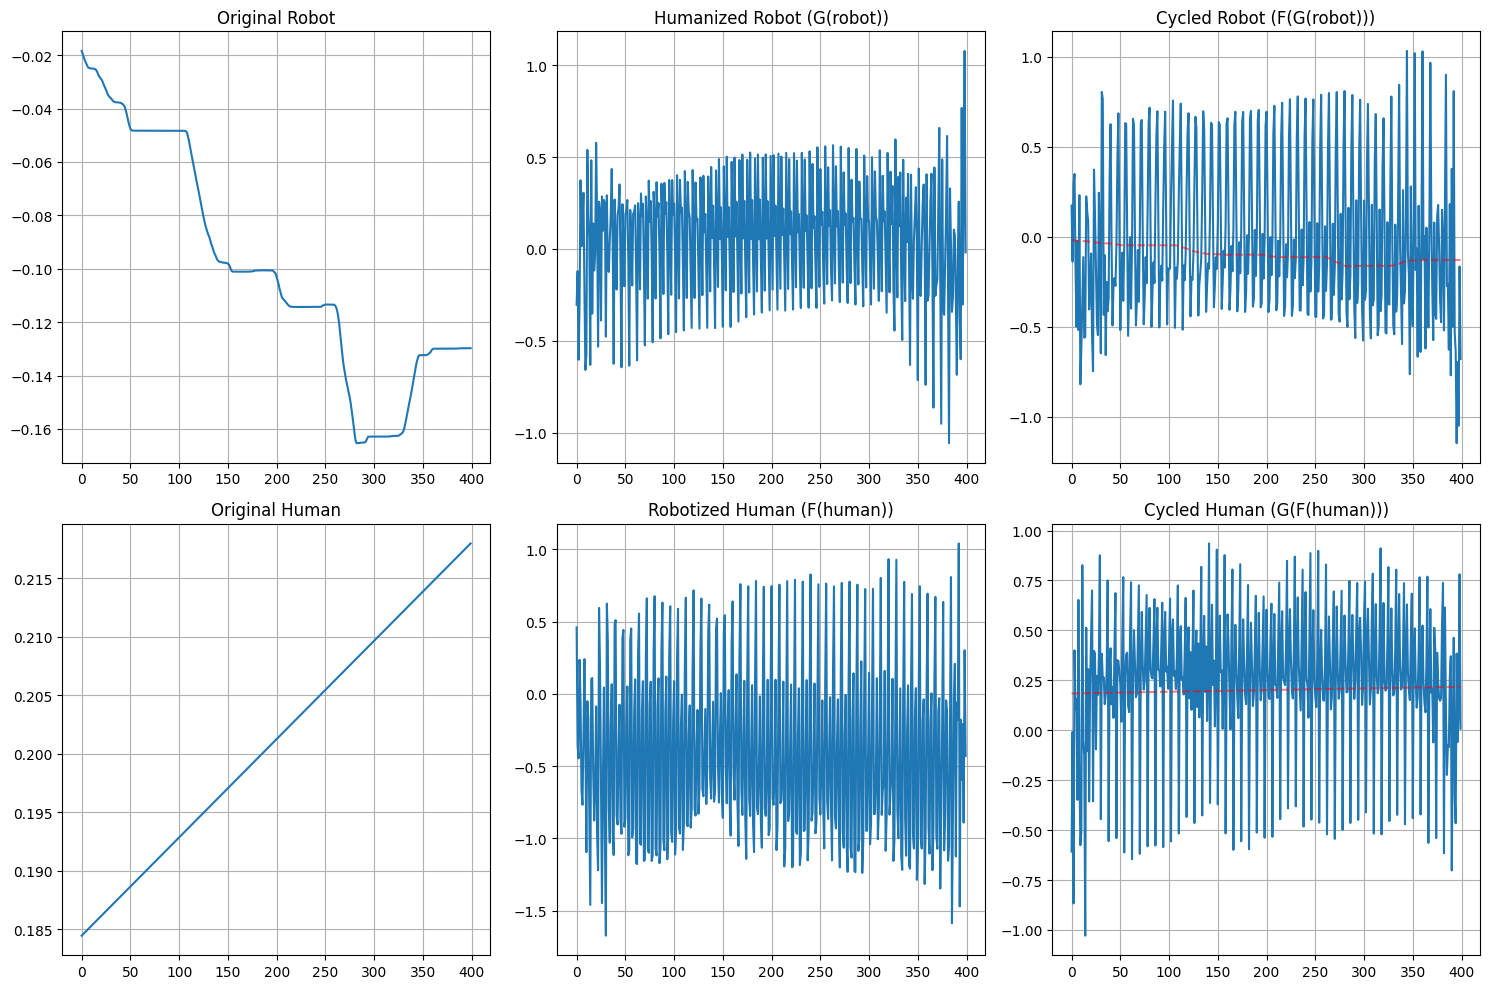

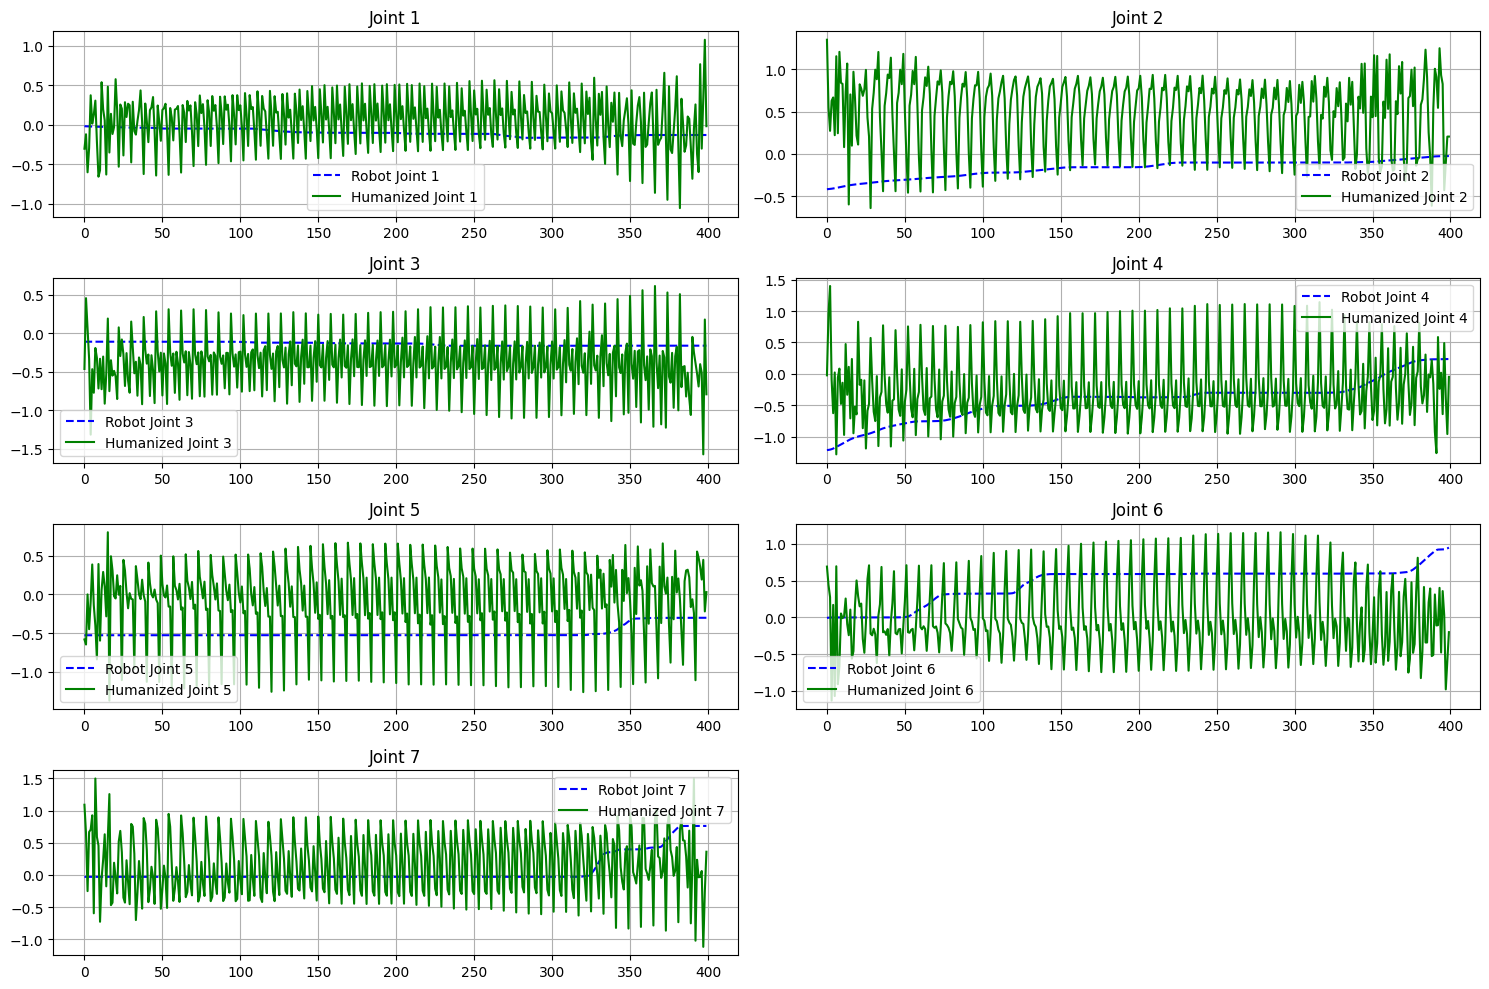

Epoch 60/1000
Generator Loss: 19.6722
Discriminator H Loss: 0.1753
Discriminator R Loss: 0.1531
Cycle Loss: 12.0598
Identity Loss: 6.4002
Smoothness Loss: 268.8353
Biomechanical Loss: 0.1473
Correlation Loss: 7206766.0000
--------------------------------------------------


KeyboardInterrupt: 

In [20]:
# Example usage
if __name__ == "__main__":
    # Load joint data - adjust path to your data location
    data = load_joint_data("joint_data/", pattern="*.csv")

    robot_data = data['robot_data']
    human_data = data['human_data']

    human_data = remove_outliers(human_data, m=3.0)
    robot_data, human_data = normalize_domains(robot_data, human_data)

    # Analyze the data
    analyze_movements(robot_data, human_data)

    # Create and train the CycleGAN
    gan = SomaboticsJointCycleGAN(sequence_length=400, n_joints=7)

    # Train for fewer epochs for demonstration
    history = gan.train(robot_data, human_data, epochs=1000, batch_size=16)

    # Save the model
    gan.G.save("robot2human_generator.keras")
    gan.F.save("human2robot_generator.keras")

    # Load a new robot movement and humanize it
    # This is just an example - replace with your actual new robot data
    test_robot_movement = robot_data[:1]  # Just using the first sample for demonstration

    # Humanize the robot movement
    humanized_movement = gan.humanize_robot_movement(test_robot_movement)

    # Visualize the results
    plt.figure(figsize=(15, 10))
    for j in range(7):
        plt.subplot(4, 2, j+1)
        plt.plot(test_robot_movement[0, :, j], 'b--', label='Robot')
        plt.plot(humanized_movement[0, :, j], 'g-', label='Humanized')
        plt.title(f'Joint {j+1}')
        plt.legend()
        plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Save the humanized movement to CSV
    humanized_df = pd.DataFrame(humanized_movement[0])
    humanized_df.to_csv("humanized_robot_movement.csv", index=False)

    print("Humanized movement saved to humanized_robot_movement.csv")

In [12]:
!mjpython /Users/pszkw/mujoco_panda/mujoco_panda/paused_movement.py /Users/pszkw/humanized_robot_movement.csv

Starting playback...


In [45]:
human_data.shape

(7493, 3000, 7)

In [46]:
robot_data.shape

(562, 3000, 7)